In [142]:
import json
import argparse
from collections import defaultdict
import glob
from os import path
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import csv



In [3]:
# parser = argparse.ArgumentParser(
#     description='Adds metadata to a json file')
# parser.add_argument('file')
# args = parser.parse_args()

# file = args.file
files = glob.glob('data/*.json')
confs = defaultdict(dict)
for file in files:
    data = json.load(open(file, 'r'))
    conf_name = path.basename(file).split('.')[0]
    conf_name, year = conf_name.split('_')
    data = json.load(open(file, 'r'))
    for paper in data:
        try:
            paper['text'] = open(f"data/pdfs/{paper['id']}.txt", 'r').read().lower()
        except:
            paper['text'] = "N/A"
            pass
    confs[conf_name][year] = data




In [149]:
begin = time.time()
synonyms = {
    'facebook': ["facebook ai research", 'fb.com'],
    'google': ['google.com', 'google brain'],
    'pytorch': ['pytorch', 'allennlp', 'opennmt-py', 'torchvision'],
    'tensorflow': ['tensorflow', 'opennmt-tf'],
    'keras': ['keras'],
    'stanford': ['@cs.stanford.edu', '@stanford.edu'],
    'mit': ['@csail.mit.edu', '@mit.edu'],
    'uw': ['@cs.washington.edu', '@washington.edu'],
    'cornell': ['@cs.cornell.edu', '@cornell.edu'],
    'cmu': ['@cmu.edu', '@cs.cmu.edu'],
    'theano': ['theano'],
#     'architecture search': ['architecture search'],
#     'gan': ['generative adversarial network'],
#     'rl': ['reinforcement learning'],
#     'bayesian': ['bayesian'],
#     'meta-learning': ['meta-learning', 'metalearning'],
#     'few-shot': ['few shot', 'few-shot', 'one shot', 'one-shot'],
#     'graph': ['graph neural network'],
#     'generative': ['generative model'],
#     'adversarial': ['adversarial attack', 'ifgsm'],
}
for k, v in synonyms.items():
    synonyms[k] = [i.lower() for i in v]
    
words = set([i for k,v in synonyms.items() for i in v])
mapping = defaultdict(list)
for k, vs in synonyms.items():
    for v in vs:
        mapping[v].append(k)
    mapping[v].append(v)
        
word_sets = defaultdict(lambda: defaultdict(lambda: defaultdict(set)))
for conf in confs:
    for year in confs[conf]:
        data = confs[conf][year]
        word_set = word_sets[conf][year]
        for paper in data:
            for word in words:
                if word in paper['text']:
                    if word in mapping:
                        for key in mapping[word]:
                            word_set[key].add(paper['id'])

print(time.time() - begin)  

5.503965854644775


In [150]:
conf_month = {
    'eccv': 'september',
    'acl': 'july',
    'naacl': 'june',
    'acl': 'august',
    'icml': 'june',
    'cvpr': 'june',
    'nips': 'december',
    'aistats': 'april',
    'colt': 'june',
    'iclr': 'may',
    'iccv': 'november',
    'emnlp': 'november'
}
conf_month = {
    k: time.strptime(v, '%B').tm_mon for k, v in conf_month.items()}

eccv
2018
3
acl
2017
0
2018
0
naacl
2018
0
2019
0
icml
2017
0
2018
0
2019
3
cvpr
2015
0
2016
0
2017
0
2018
2
2019
8
nips
2015
0
2016
0
2017
0
2018
1
aistats
2018
0
2019
0
iclr
2018
0
2019
5
iccv
2017
0
emnlp
2017
0
2018
1


Text(0.5, 1.0, '#Pytorch vs Tensorflow: percentage of unique mentions')

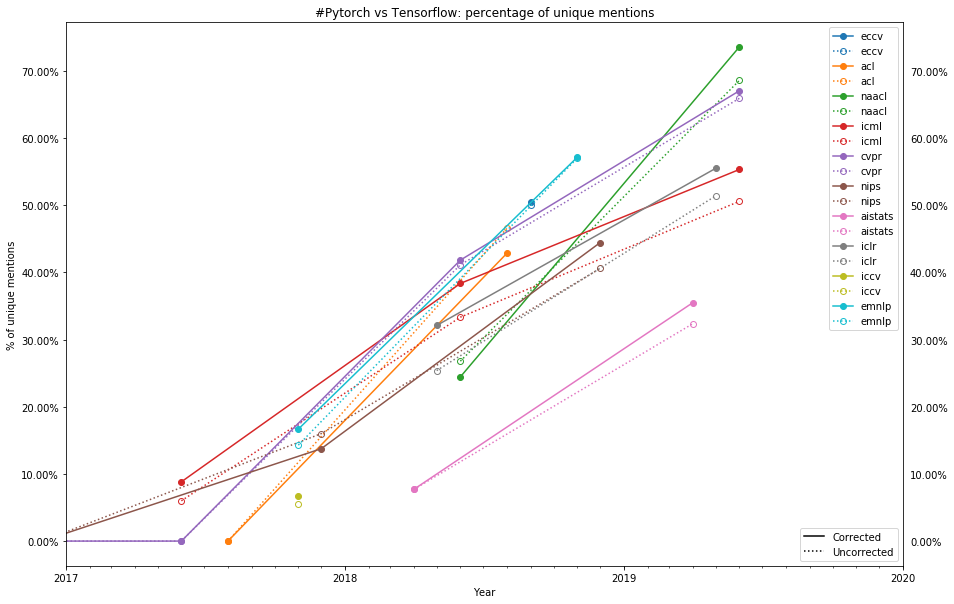

In [151]:
# condition = 'adversarial'
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.set_xlim(np.datetime64('2017'), np.datetime64('2020'))
ax.set_facecolor((1,1,1,1))
plt.rcParams["figure.figsize"] = (15,10)
plt.tick_params(labelright=True)
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
nlp_confs = ['naacl', 'acl', 'emnlp']
cv_confs = ['cvpr', 'eccv', 'iccv']
ml_confs = ['nips', 'iclr', 'icml']
csvfile = open('data.csv', 'w')
writer = csv.writer(csvfile)
for conf in confs:
    if conf == 'colt':
        continue
    pytorch = []
    pytorch_corr = []
    tf = []
    tf_corr = []
    dates = []
    print(conf)
    for year in sorted(confs[conf]):
        ws = word_sets[conf][year]
        date = np.datetime64(f"{year}-{conf_month[conf]:02}")
        dates.append(date)

        pytorch_set = ws['pytorch']# & ws[condition]
        tf_set = ws['tensorflow'] #& ws[condition]
        biased_set = ws['facebook'] | ws['google']
        pytorch.append(len(pytorch_set))
        tf.append(len(tf_set))
        pytorch_corr.append(len(pytorch_set - biased_set))
        tf_corr.append(len(tf_set - biased_set))
        writer.writerow([conf, f"{conf_month[conf]:02}/{year[2:]}", pytorch_corr[-1], tf_corr[-1]])

        print(year)
#         print("total papers", len(confs[conf][year]))
#         print("ratio: ", len(ws['pytorch'] | ws['tensorflow'])/len(confs[conf][year]))
#         print("pytorch", len(ws['pytorch']))
        print(len(ws['torchvision']))
#         print("pytorch independent", len(ws['pytorch'] - ws['facebook']))
#         print("tensorflow", len(ws['tensorflow']))
#         print("tensorflow independent", len(ws['tensorflow'] - ws['google']))
#     print()
#     plt.figure()
    c=prop_cycle[0]
    prop_cycle = prop_cycle[1:] + prop_cycle[:1]
#     alpha = 1.0 if conf in ['naacl', 'acl', 'emnlp'] else 0.1
#     alpha = 1.0 if conf in nlp_confs else 0.2
    alpha = 1.0
    plt.plot(dates, 
            [a/(a+b) if a+b > 0 else None for a,b in zip(pytorch_corr, tf_corr)],
#              pytorch_corr,
            label = conf,
            marker = 'o',
             color = c,
            alpha=alpha)
    plt.plot(dates, 
             [a/(a+b) if a+b > 0 else None for a,b in zip(pytorch, tf)],
#              tf_corr,
            label = conf,
            marker = 'o',
            markerfacecolor='none',
            linestyle=':',
            color=c,
            alpha=alpha)
    
    plt.legend()
plt.ylabel('% of unique mentions')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.xlabel('Year')
#     plt.plot(dates, pytorch, color='blue')
#     plt.plot(dates, tf, color='orange')
solid_line = Line2D([0], [0], color='black', label='Corrected')
dashed_line = Line2D([0], [0], linestyle=':', color='black', label='Uncorrected')
csvfile.close()

legend1 = plt.legend(handles=[solid_line, dashed_line], loc=4)
plt.legend()
plt.gca().add_artist(legend1)

plt.title("#Pytorch vs Tensorflow: percentage of unique mentions")

In [115]:
conf = 'naacl'
for year in sorted(confs[conf]):
    ws = word_sets[conf][year]

    print(year)
    print("total papers", len(confs[conf][year]))
    print("pytorch", len(ws['pytorch']))
    print("pytorch independent", len(ws['pytorch'] - ws['facebook']))
    print("tensorflow", len(ws['tensorflow']))
    print("tensorflow independent", len(ws['tensorflow'] - ws['google']))
    print()


2018
total papers 330
pytorch 15
pytorch independent 14
tensorflow 41
tensorflow independent 35

2019
total papers 451
pytorch 72
pytorch independent 69
tensorflow 33
tensorflow independent 24



In [92]:
pytorch = set()
tf = set()
fb = set()
google = set()
for i in word_sets.values():
    for j in i.values():
        pytorch |= j['pytorch']
        tf |= j['tensorflow']
        fb |= j['facebook']
        google |= j['google']
print(len(pytorch & fb)/len(fb))
print(len(google & tf)/len(google))

0.1791907514450867
0.23529411764705882
